In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

# Convolutional Neural Networks

ConvNets are particularly well suited for data that has a spatial component to it. Things like images, audio, and text. Load the provided MNIST dataset from Tensorflow, split into training and test, and then display a few examples.

In [7]:
class_dict = {0: 't-shirt',
              1: 'trouser',
              2: 'pullover',
              3: 'dress',
              4: 'coat',
              5: 'sandal',
              6: 'shirt',
              7: 'sneaker',
              8: 'bag',
              9: 'ankle boot'}

(48000, 28, 28, 1) (48000, 10) (12000, 28, 28, 1) (12000, 10)


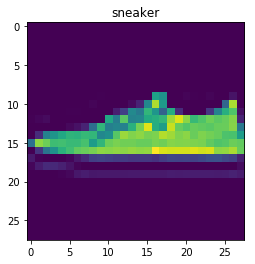

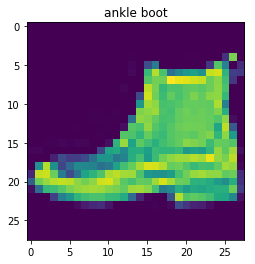

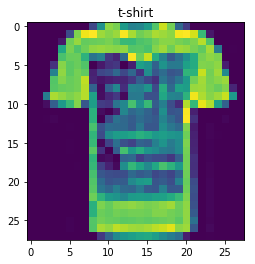

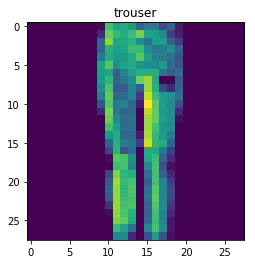

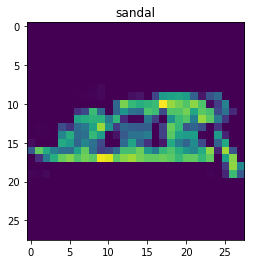

In [8]:
lblr = LabelBinarizer()

data_train = pd.read_csv('Fashion_MNIST/fashion-mnist_train.zip', compression='zip')
data_test = pd.read_csv('Fashion_MNIST/fashion-mnist_test.zip', compression='zip')

img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

X = np.array(data_train.iloc[:, 1:])
y = lblr.fit_transform(np.array(data_train.iloc[:, 0]))

#Here we split validation data to optimiza classifier during training
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)

#Test data
X_test = np.array(data_test.iloc[:, 1:])
y_test = lblr.transform(np.array(data_test.iloc[:, 0]))

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')
X_train /= 255
X_test /= 255
X_val /= 255

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

for i in range(5):
    plt.title(class_dict[lblr.inverse_transform(y_train[i].reshape(1,10))[0]])
    plt.imshow(X_train[i].squeeze())
    plt.show()

Again, we will need placeholders for our batches when we use minibatch gradient descent.

In [9]:
with tf.name_scope('input_placeholder'):
    X = tf.placeholder(tf.float32, shape=(None, 28, 28, 1), name='X')
    
with tf.name_scope('targets_placeholder'):
    y = tf.placeholder(tf.float32, shape=(None, 10), name='y')

Set up our NN hyperparameters

In [10]:
LR = 0.001
EPOCHS = 15
BATCHSIZE = 32

Much like our vanailly neural network example, we will create generic layer functions that take certain values as parameters. These functions will allow us to quickly and easily set up our Convolutional neural network with little redudancy. They will also allow us to rapidly prototype different architectures, if we wanted more or less layers in any region of the network

In [11]:
def conv_layer(X, in_dims, n_kernels, kernel_size, name, activation=None):
    '''
    Sets up a convolutional layer to be used to build a CNN. 
    
    Parameters:
    X: input data for the layer
    in_dims: number of channels incoming to this layer
    n_kernels: number of convolutional kernels to use in the layer
    kernel_size: the size of each kernel as (kernel_size, kernel_size)
    name: the name of the scope to be used with this layer
    activation: the tensorflow nonlinearity to be used for each neuron
    
    Returns:
    Tensorflow graph description representing the constructed layer
    '''
    with tf.name_scope(name):
        init = tf.truncated_normal([kernel_size, kernel_size, in_dims, n_kernels], stddev=0.1)
        W = tf.Variable(init, name='kernel_weights_{}'.format(name))
        b = tf.Variable(tf.constant(0.1, shape=[n_kernels]))
        conv = tf.nn.conv2d(X, W, strides=[1,1,1,1], padding='SAME') + b
        if activation is not None:
            return activation(conv)
        else:
            return conv
        
def max_pool(X, pool_size, name):
    '''
    Sets up a pooling layer to be used to build a CNN. 
    
    Parameters:
    X: input data for the layer
    pool_size: the window size for the maxpool operation in (pool_size, pool_size)
    name: the name of the scope to be used with this layer

    Returns:
    Tensorflow graph description representing the constructed layer
    '''
    with tf.name_scope(name):
        return tf.nn.max_pool(X, ksize=[1, pool_size, pool_size, 1], 
                              strides=[1, pool_size, pool_size, 1], padding='SAME')
        
def dense_layer(X, n_units, name, activation=None):
    '''
    Sets up a hidden layer to be used to build a multilayer perceptron. 
    
    Initializes the weights of the neurons using a normal distribution with
    standard deviation equal to 2 / sqrt(input_dimension + number_neurons)
    
    Parameters:
    X: input data for the layer
    n_units: number of neurons to use in the layer
    name: the name of the scope to be used with this layer
    activation: the tensorflow nonlinearity to be used for each neuron
    
    Returns:
    Tensorflow graph description representing the constructed layer
    '''
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs + n_units)
        init = tf.truncated_normal((n_inputs, n_units), stddev=stddev)
        W = tf.Variable(init, name='hidden_weights_{}'.format(name))
        b = tf.Variable(tf.zeros([n_units]), name='bias_{}'.format(name))
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z
        
def output_layer(X, n_units, name):
    '''
    Same as dense layer but doesn't take an activation
    '''
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs + n_units)
        init = tf.truncated_normal((n_inputs, n_units), stddev=stddev)
        W = tf.Variable(init, name='hidden_weights_{}'.format(name))
        b = tf.Variable(tf.zeros([n_units]), name='bias_{}'.format(name))
        logits = tf.add(tf.matmul(X, W), b, name='logits_{}'.format(name))
        
    return logits

# Exercise

Build a convolutional neural network using the layer definitions that we created above. Try to come up with an architecture to maximize test set accuracy.

### Solution

In [12]:
# build the network
with tf.name_scope('cnn'):
    conv_1 = conv_layer(X, in_dims=1, n_kernels=8, kernel_size=5, name='conv_a', activation=tf.nn.relu)
    pool_1 = max_pool(conv_1, pool_size=2, name='pool_a')
    
    conv_2 = conv_layer(pool_1, in_dims=8, n_kernels=16, kernel_size=5, name='conv_b', activation=tf.nn.relu)
    pool_2 = max_pool(conv_2, pool_size=2, name='pool_b')
    
    flat = tf.reshape(pool_2, [-1, 7*7*16])
    
    dense = dense_layer(flat, 32, name='dense_layer', activation=tf.nn.relu)
    y_logits = output_layer(dense, 10, name='output')

Set up our loss and training algorithms. We'll use `Adam` here, which is a tweak on the way that stochastic gradient descent works.

In [13]:
with tf.name_scope('loss'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_logits))
    
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(LR, name='adam_optimizer').minimize(loss)
    
with tf.name_scope('prediction'):
    predictions = tf.nn.softmax(y_logits)
    
def accuracy(pred_probs, true_labels):
    corrects = np.equal(np.argmax(pred_probs, 1), np.argmax(true_labels, 1))
    return np.mean(corrects)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



Train our network, using essentially the same methodology as the other notebooks. 

In [14]:
#saver = tf.train.Saver()
init = tf.global_variables_initializer()

losses = []
n_samples = X_train.shape[0]
with tf.Session() as sess:
    sess.run(init)
    
    for e in range(EPOCHS):
        # shuffle the training data
        X_train, y_train = shuffle(X_train, y_train)
        for i in range((n_samples + BATCHSIZE - 1) // BATCHSIZE):
            sl = slice(i * BATCHSIZE, (i+1) * BATCHSIZE)
            X_b = X_train[sl]
            y_b = y_train[sl]
            _, train_loss = sess.run([train_step, loss], feed_dict={X: X_b, y: y_b})
            losses.append(train_loss)
            
        if e % 3 == 0:
            valid_preds, valid_loss = sess.run([predictions, loss], feed_dict={X: X_val, y: y_val})
            valid_acc = accuracy(valid_preds, y_val)
            print("Epoch:", e,
                  "Current loss:", train_loss,
                  "Valid loss:", valid_loss,
                  "Valid_acc:", valid_acc)

    # We use a built-in TF helper to export variables to constants
    output_node_name = 'cnn/output/logits_output'
    output_graph_def = tf.graph_util.convert_variables_to_constants(
        sess, # The session is used to retrieve the weights
        tf.get_default_graph().as_graph_def(), # The graph_def is used to retrieve the nodes 
        output_node_name.split(",") # The output node names are used to select the usefull nodes
    ) 

    # Finally we serialize and dump the output graph to the filesystem
    with tf.gfile.GFile('./saved_model/cnn_mnist.pb', "wb") as f:
        f.write(output_graph_def.SerializeToString())
        
    saver = tf.train.Saver()
    saver.save(sess, './saved_model/cnn_mnist.ckpt')

Epoch: 0 Current loss: 0.5812398 Valid loss: 0.40498412 Valid_acc: 0.8525833333333334
Epoch: 3 Current loss: 0.446702 Valid loss: 0.30274796 Valid_acc: 0.8894166666666666
Epoch: 6 Current loss: 0.2349539 Valid loss: 0.274631 Valid_acc: 0.8995833333333333
Epoch: 9 Current loss: 0.06648533 Valid loss: 0.27739203 Valid_acc: 0.9021666666666667
Epoch: 12 Current loss: 0.11783339 Valid loss: 0.28116167 Valid_acc: 0.8986666666666666
INFO:tensorflow:Froze 8 variables.
Converted 8 variables to const ops.


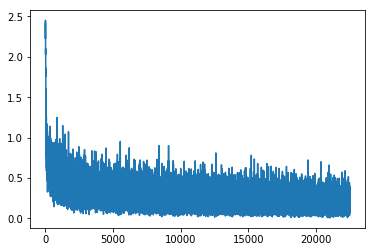

In [15]:
plt.plot(np.array(losses))
plt.show()

Collect the predictions for the test set.

In [16]:
# best weight values are saved in the checkpoint
with tf.Session() as sess:
    # restore the session that we used to train the model
    saver.restore(sess, './saved_model/cnn_mnist.ckpt')
    # get the predictions for all of the images in the testing dataset
    preds = sess.run(predictions, feed_dict={X: X_test})
    pred_val = tf.argmax(preds, 1).eval()

INFO:tensorflow:Restoring parameters from ./saved_model/cnn_mnist.ckpt


Display some of the images and their predicted values.

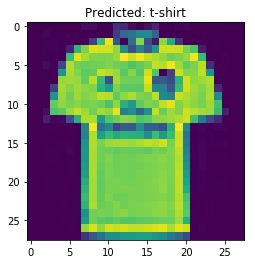

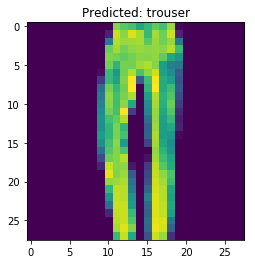

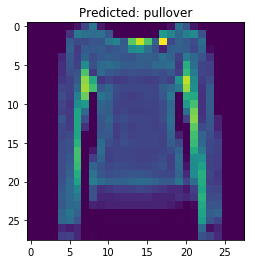

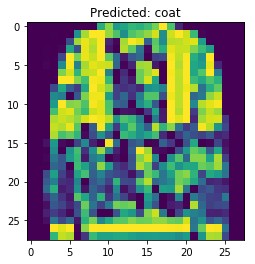

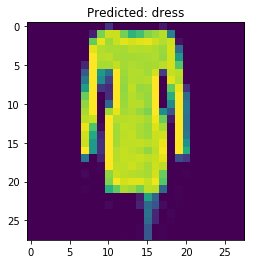

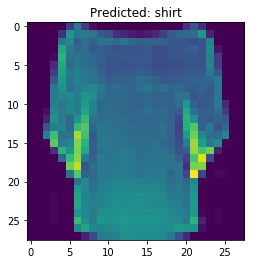

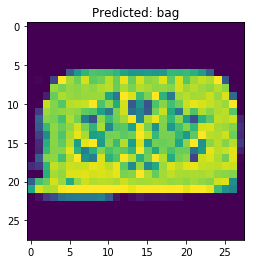

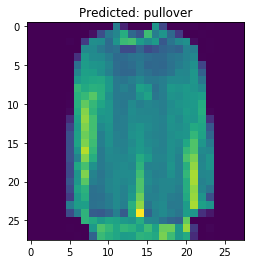

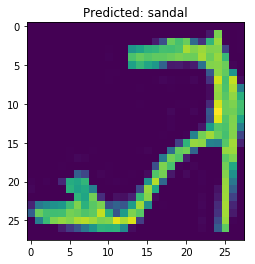

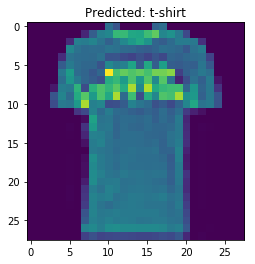

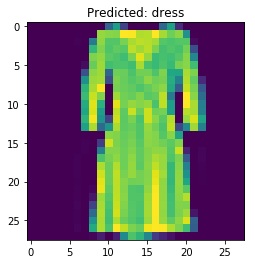

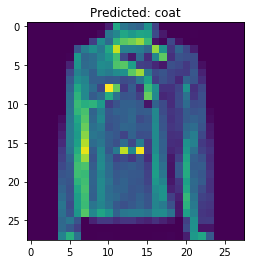

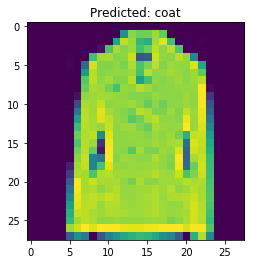

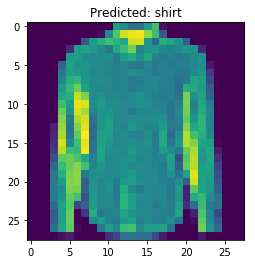

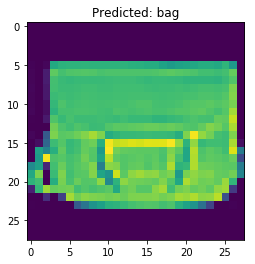

In [18]:
for j in range(15):
    plt.imshow(X_test[j].squeeze())
    plt.title('Predicted: {}'.format(class_dict[pred_val[j]]))
    plt.show()